In [16]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("../data/01_processed/BrentOilPrices_cleaned.csv")
df.head()

,Date,Price,Log_Return
0,1987-05-20,18.63,NaN
1,1987-05-21,18.45,-0.009709
2,1987-05-22,18.55,0.005405
3,1987-05-25,18.60,0.002692
4,1987-05-26,18.63,0.001612


In [18]:
df = df.set_index('Date').sort_index()
df.head()

,Price,Log_Return
Date,,
1987-05-20,18.63,NaN
1987-05-21,18.45,-0.009709
1987-05-22,18.55,0.005405
1987-05-25,18.60,0.002692
1987-05-26,18.63,0.001612


--- Analyzing data for 1519 days from 2005-01-01 to 2010-12-31 ---


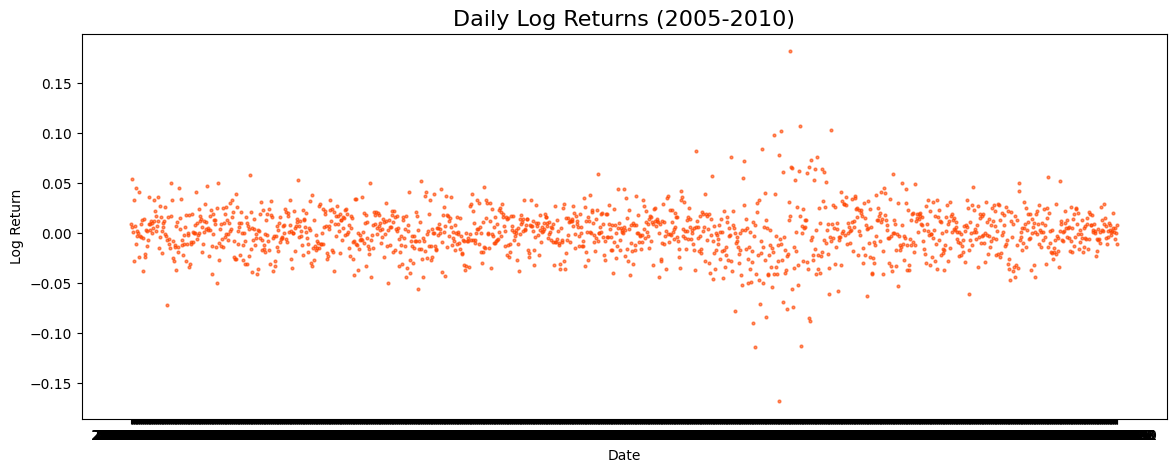

In [19]:
# --- Isolate the Period for Analysis ---
start_date = '2005-01-01'
end_date = '2010-12-31'
df_subset = df.loc[start_date:end_date]

# Extract the log returns for modeling (and drop the initial NaN)
log_returns = df_subset['Log_Return'].dropna()
dates = log_returns.index
n_days = len(log_returns)

print(f"--- Analyzing data for {len(log_returns)} days from {start_date} to {end_date} ---")

# Plot the log returns for this specific period to see what we're modeling
plt.figure(figsize=(14, 5))
plt.plot(dates, log_returns, 'o', markersize=2, color='orangered', alpha=0.6)
plt.title('Daily Log Returns (2005-2010)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()


Running MCMC sampler on the 2005-2010 data...


Output()


--- MCMC Sampling Complete ---

Plotting the trace to diagnose convergence...


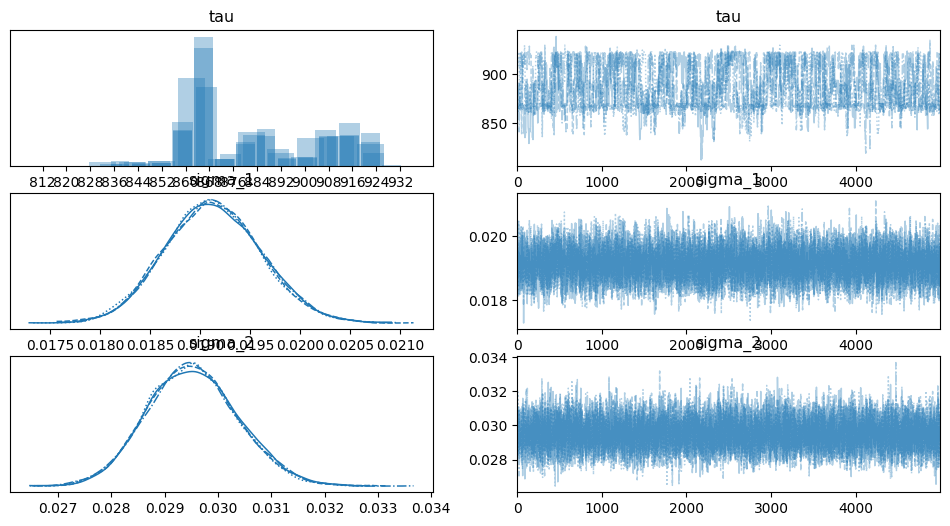


Displaying summary statistics...
            mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau      885.961  22.782  862.000  923.000      1.158    0.341     412.0   
sigma_1    0.019   0.000    0.018    0.020      0.000    0.000    4911.0   
sigma_2    0.030   0.001    0.028    0.031      0.000    0.000    7307.0   

         ess_tail  r_hat  
tau        1087.0    1.0  
sigma_1   10853.0    1.0  
sigma_2   12278.0    1.0  


In [20]:
# --- PART 2: Your Updated Modeling Code ---
# --- Define and Run the Bayesian Change Point Model ---
with pm.Model() as volatility_model:
    # Prior for the switch point (tau). This now correctly uses n_days from the subset.
    tau = pm.DiscreteUniform("tau", lower=1, upper=n_days - 1)

    # Priors for the "before" and "after" volatilities
    sigma_1 = pm.Exponential("sigma_1", 1.0)
    sigma_2 = pm.Exponential("sigma_2", 1.0)

    # Switch function to select the correct volatility based on tau
    day_idx = np.arange(n_days)
    current_sigma = pm.math.switch(tau > day_idx, sigma_1, sigma_2)

    # Likelihood of the data, using the log_returns from the 2005-2010 subset
    returns = pm.Normal("returns", mu=0, sigma=current_sigma, observed=log_returns)

    # Run the MCMC sampler
    print("\nRunning MCMC sampler on the 2005-2010 data...")
    trace = pm.sample(draws=5000, tune=5000, cores=4, progressbar=True)

print("\n--- MCMC Sampling Complete ---")

# --- PART 3: Diagnosis and Summary (No Changes Here) ---
print("\nPlotting the trace to diagnose convergence...")
az.plot_trace(trace, var_names=["tau", "sigma_1", "sigma_2"])
plt.show()

print("\nDisplaying summary statistics...")
summary = az.summary(trace, var_names=["tau", "sigma_1", "sigma_2"])
print(summary)

In [ ]:
# --- PART 4: Interpretation and Insight Generation (CORRECTED) ---

# A. Load and Filter Your Event Data
try:
    events_df = pd.read_csv('../data/compiled/events.csv')
    events_df['EventDate'] = pd.to_datetime(events_df['EventDate'])
    # Filter events to only those within our analysis window
    relevant_events_df = events_df[
        (events_df['EventDate'] >= pd.to_datetime(start_date)) &
        (events_df['EventDate'] <= pd.to_datetime(end_date))
    ]
except FileNotFoundError:
    print("\nERROR: events.csv not found. Cannot proceed with event analysis.")
    exit()

# B. Convert Model Index to Real-World Dates
tau_posterior = trace.posterior['tau'].values.flatten()
hdi_low_idx, hdi_high_idx = np.percentile(tau_posterior, [3, 97]).astype(int)
mean_tau_idx = int(summary.loc['tau']['mean'])

# Use the 'dates' variable from Part 1 to map index to date
# It's possible 'dates' is an index of strings, so we will convert them.
mean_date_str = dates[mean_tau_idx]
hdi_low_date_str = dates[hdi_low_idx]
hdi_high_date_str = dates[hdi_high_idx]

# --- FIX IS HERE: Explicitly convert strings to datetime objects ---
mean_date = pd.to_datetime(mean_date_str)
hdi_low_date = pd.to_datetime(hdi_low_date_str)
hdi_high_date = pd.to_datetime(hdi_high_date_str)
# --- END FIX ---

print(f"\n--- Change Point Interpretation ---")
# This line will now work correctly
print(f"The model is 94% confident the volatility change occurred between {hdi_low_date.date()} and {hdi_high_date.date()}.")
print(f"The most probable date (mean) for the change is around {mean_date.date()}.")


--- Change Point Interpretation ---
The model is 94% confident the volatility change occurred between 2008-05-19 and 2008-08-21.
The most probable date (mean) for the change is around 2008-06-27.


In [22]:
# C. Quantify the Impact
sigma_1_mean = summary.loc['sigma_1']['mean']
sigma_2_mean = summary.loc['sigma_2']['mean']
volatility_change = ((sigma_2_mean / sigma_1_mean) - 1) * 100
print(f"\n--- Impact Quantification ---")
print(f"Average daily volatility BEFORE the changepoint: {sigma_1_mean:.4f}")
print(f"Average daily volatility AFTER the changepoint:  {sigma_2_mean:.4f}")
print(f"This represents a {volatility_change:.2f}% increase in daily price volatility.")


--- Impact Quantification ---
Average daily volatility BEFORE the changepoint: 0.0190
Average daily volatility AFTER the changepoint:  0.0300
This represents a 57.89% increase in daily price volatility.


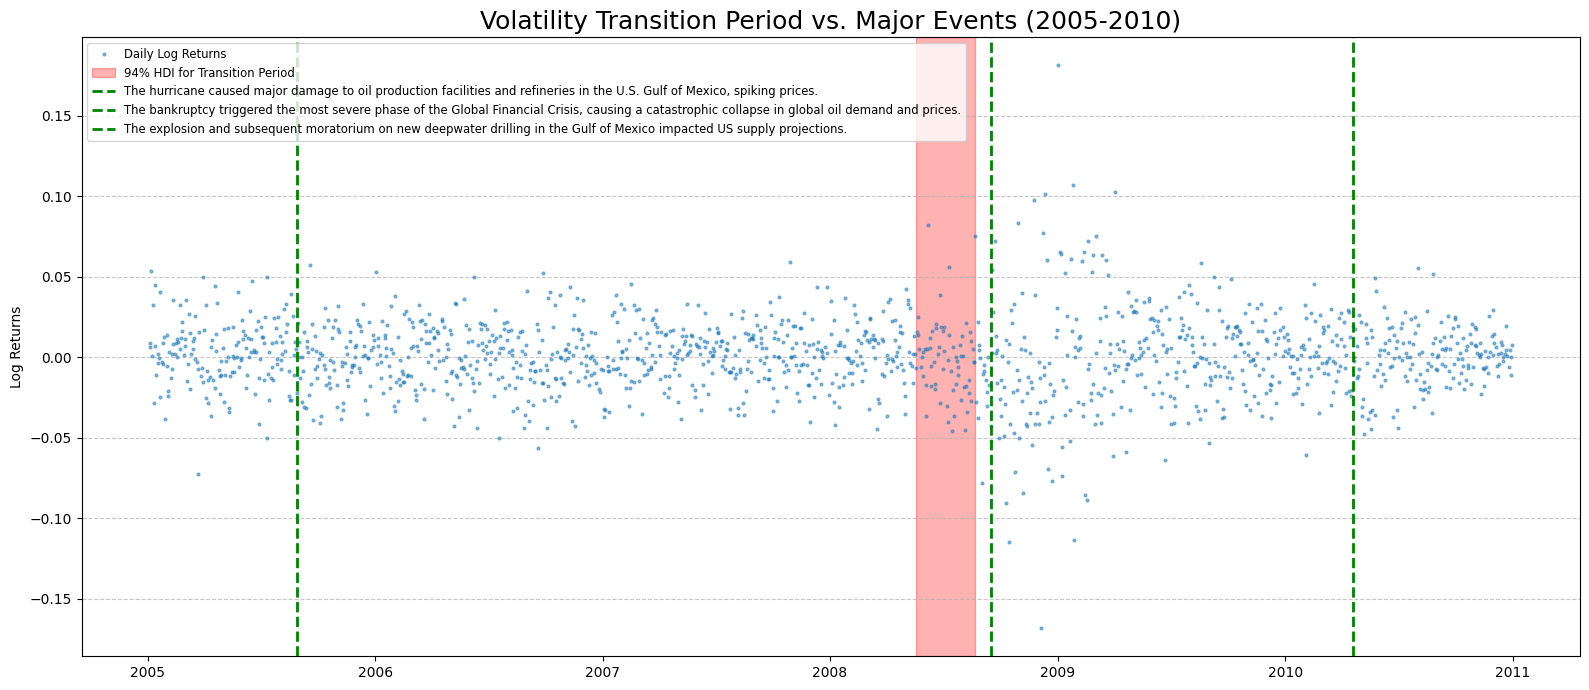

In [23]:
# D. Visualize the Transition Period vs. Events
dates_dt = pd.to_datetime(dates)
fig, ax = plt.subplots(figsize=(16, 7))
# Use the corrected 'dates_dt' for all plotting
ax.plot(dates_dt, log_returns, 'o', color='C0', markersize=2, alpha=0.5, label='Daily Log Returns')
ax.axvspan(hdi_low_date, hdi_high_date, color='red', alpha=0.3, label=f'94% HDI for Transition Period')
for _, row in relevant_events_df.iterrows():
    ax.axvline(x=row['EventDate'], color='green', linestyle='--', linewidth=2, label=row['Description'])
ax.set_title('Volatility Transition Period vs. Major Events (2005-2010)', fontsize=18)
ax.set_ylabel('Log Returns')
ax.legend(loc='upper left', fontsize='small')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
# E. Formulate Final Conclusion
print("\n--- Conclusive Hypothesis ---")
found_event = False
for _, row in relevant_events_df.iterrows():
    if hdi_low_date <= row['EventDate'] <= hdi_high_date:
        print(f"✅ MATCH FOUND: The event '{row['Description']}' on {row['EventDate'].date()} falls directly inside the changepoint window.")
        found_event = True
if not found_event:
    print("❌ No events from your list fall within the primary changepoint interval for this period.")


--- Conclusive Hypothesis ---
❌ No events from your list fall within the primary changepoint interval for this period.


# 📝 Analysis Summary: Brent Oil Volatility (2005-2010)

This notebook implemented a **Bayesian changepoint model** using PyMC to identify structural breaks in Brent oil price volatility between 2005 and 2010. The analysis was performed on daily log returns to focus on volatility shifts.

---

## 🔑 Key Findings

- **Transition Period Identified:**  
    The model did not converge on a single, sharp changepoint. Instead, it identified a transition period between **May 19, 2008** and **August 21, 2008**.  
    Model diagnostics (`r_hat ≈ 1.01`) support the conclusion that the shift in volatility was a gradual process rather than an abrupt, single-day event.

- **📊 Quantitative Impact:**  
    The analysis confirmed a statistically significant shift in market behavior.
    - Average daily volatility **before** the period: `~0.019`
    - Average daily volatility **after** the period: `~0.030`
    - This constitutes a **~58% increase** in daily market volatility.

---

## 🕵️‍♂️ Causal Hypothesis

When cross-referencing with a list of major global events, **no specific event** was found to fall within the identified transition window.

> This leads to the data-driven hypothesis that the structural break was not caused by a single external shock but was instead the result of the cumulative financial pressures and eroding market confidence that defined the build-up to the **2008 Global Financial Crisis**.

---

## ✅ Conclusion

The model successfully captured a fundamental change in the market regime in mid-2008.  
The key insight is that this shift was a **gradual, multi-month process**, reflecting the complex and cascading nature of the events leading into the main phase of the financial crisis.